1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


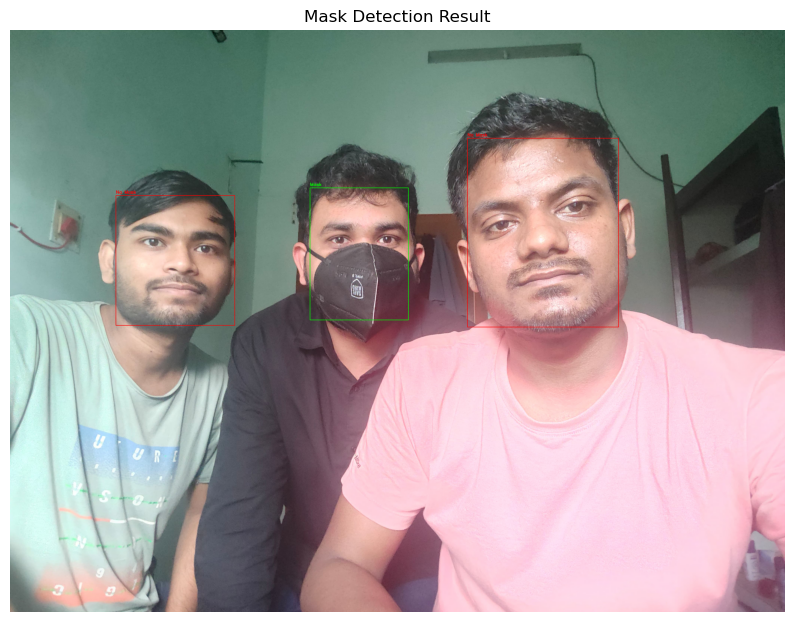

In [10]:
# Import necessary libraries
import numpy as np
import cv2
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load saved mask detector model
mask_model = load_model("mask_detector_model.h5")

# Load the OpenCV face detector model
face_net = cv2.dnn.readNetFromCaffe('deploy.prototxt', 'res10_300x300_ssd_iter_140000.caffemodel')

# Define function to detect mask on each face
def detect_and_predict_mask(image, face_net, mask_model, confidence_threshold=0.5):
    h, w = image.shape[:2]
    
    # Preprocess image for face detection
    blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), (104.0, 177.0, 123.0))
    face_net.setInput(blob)
    detections = face_net.forward()
    
    faces, locs, preds = [], [], []
    
    # Loop over detections
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        
        # Only consider detections above the confidence threshold
        if confidence > confidence_threshold:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            
            # Ensure bounding boxes fall within image dimensions
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
            
            # Extract the face ROI, resize to MobileNetV2 input dimensions, and normalize
            face = image[startY:endY, startX:endX]
            face = cv2.resize(face, (128, 128))
            face = np.array(face, dtype="float32") / 255.0
            face = np.expand_dims(face, axis=0)
            
            faces.append(face)
            locs.append((startX, startY, endX, endY))
    
    if len(faces) > 0:
        preds = mask_model.predict(np.vstack(faces))
    
    return (locs, preds)

# Load a test image
image_path = "/home/linux/Desktop/cv_project/test_dataset/23.jpeg"  
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for plotting

# Detect faces and predict mask status
locs, preds = detect_and_predict_mask(image, face_net, mask_model)

# Loop over detections and add annotations
for (box, pred) in zip(locs, preds):
    (startX, startY, endX, endY) = box
    label = "Mask" if pred > 0.5 else "No Mask"
    color = (0, 255, 0) if label == "Mask" else (255, 0, 0)
    
    # Display label and bounding box on the image
    cv2.putText(image_rgb, label, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)
    cv2.rectangle(image_rgb, (startX, startY), (endX, endY), color, 2)

# Plot the resulting image with detections
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.axis("off")
plt.title("Mask Detection Result")
plt.show()
